## Tema 6: Transfer Learning

### Resumen
En este notebook vamos a ver como implementar el método de transfer learning.
Con ello podremos reutilizar un modelo ya entrenado en otro problema similar.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, Input, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MSE, MAE
import tensorflow as tf
from aux_func import show_history, r2_keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from time import time
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

Número de elementos en el dataset =  60000


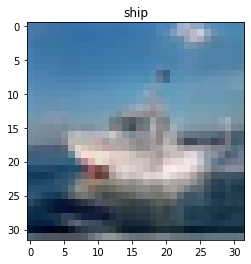

In [3]:
from tensorflow.keras.datasets import cifar10

(X_train_cifar10, y_train_cifar10), (X_validation_cifar10, y_validation_cifar10) = cifar10.load_data()
X_train_cifar10 = X_train_cifar10/255
X_validation_cifar10 = X_validation_cifar10/255

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print('Número de elementos en el dataset = ',X_train_cifar10.shape[0]+X_validation_cifar10.shape[0])
plt.title(labels[int(y_train_cifar10[62])])
plt.imshow(X_train_cifar10[62])
plt.show()

### Modelo Base
Lo primero es entrenar un modelo que más tarde podamos utilizar.
En función de la capacidad de computo del ordenador, la red la podemos hacer más pequeña para que el entrenamiento tarde menos.

In [92]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
# capas de la red
input = Input(shape=(32,32,3))
layer = input
layer = Conv2D(filters=25, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = BatchNormalization()(layer)
layer = Conv2D(filters=50, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = BatchNormalization()(layer)
layer = Conv2D(filters=100, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = BatchNormalization()(layer)
layer = Flatten()(layer)
layer = Dropout(0.5)(layer)
layer = Dense(units=500, activation='relu')(layer)
output = Dense(units=10, activation='softmax')(layer)

# creamos el modelo
model = Model(inputs=input, outputs=output)
print(model.summary())

# optimizador
optimizer = Adam(learning_rate=0.001)

# función loss
loss = SparseCategoricalCrossentropy(from_logits=False)

# métrica
metrics = ['accuracy']

# compilamos el modelo
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Podemos decidir que score queremos monitorizar, cuantas epochs esperar después del mejor score y si queremos que nos devuelva el mejor modelo.
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, mode='max')

history = model.fit(X_train_cifar10, y_train_cifar10, batch_size=30, epochs=30,
                    steps_per_epoch=1000, validation_data=(X_validation_cifar10, y_validation_cifar10), callbacks=[reduce_lr])

Model: "functional_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 25)        700       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 16, 16, 25)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 16, 16, 25)        100       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 16, 50)        11300     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 8, 8, 50)          0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 8, 8, 50)        

Guardamos el modelo para poder cargarlo más tarde

In [93]:
# guardamos el modelo
model.save('model_cifar10.h5')

Vamos a generar un dataset con características similares.
Vamos a utilizar el dataset CIFAR 100 para crear un dataset para un problema de clasificación de vehículos.

Número de elementos en el dataset =  6000


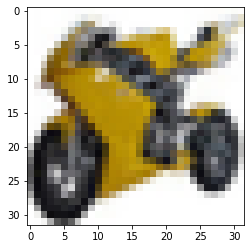

In [4]:
from tensorflow.keras.datasets import cifar100

# cargamos el dataset
(X_train_cifar100, y_train_cifar100), (X_validation_cifar100, y_validation_cifar100) = cifar100.load_data()

# Normalizamos los datos
X_train_cifar100 = X_train_cifar100/255
X_validation_cifar100 = X_validation_cifar100/255

# Cargamos los grupos de las etiquetas
(v1, y_train_cifar100_coarse), (v2, y_validation_cifar100_coarse) = cifar100.load_data(label_mode='coarse')

# Los grupos asociados a las etiquetas de vehículo son la 18 y 19
coarse_labels = [18, 19]

# Obtenemos un vector con las posiciones de los elementos que pertenecen a la clase vehículo
indexs_cond_train = np.squeeze(np.isin(y_train_cifar100_coarse, coarse_labels))
indexs_cond_validation = np.squeeze(np.isin(y_validation_cifar100_coarse, coarse_labels))

# Seleccionamos solo los elementos asociados a vehículos
X_train_vehicles = X_train_cifar100[indexs_cond_train]
y_train_vehicles = y_train_cifar100[indexs_cond_train]
X_validation_vehicles = X_validation_cifar100[indexs_cond_validation]
y_validation_vehicles = y_validation_cifar100[indexs_cond_validation]

# Obtenemos las id's de las etiquetas
unique_labels = np.unique(y_train_vehicles)

# Mostramos un ejemplo del nuevo dataset
print('Número de elementos en el dataset = ',X_train_vehicles.shape[0]+X_validation_vehicles.shape[0])
plt.imshow(X_train_vehicles[71])
plt.show()

# Reordenamos las etiquetas para numerarlas del 0 al 9
for i in range(10):
    y_train_vehicles = np.where(y_train_vehicles == unique_labels[i], i, y_train_vehicles)
    y_validation_vehicles = np.where(y_validation_vehicles == unique_labels[i], i, y_validation_vehicles)

### Nuevo modelo
Lo primero es cargar el modelo entrenado previamente

In [117]:
model = tf.keras.models.load_model('model_cifar10.h5')

Ahora vamos a crear el nuevo modelo usando parte del modelo transferido

In [118]:
# El input del nuevo modelo será el mismo que el modelo base
input = model.input

# Seleccionamos hasta que capa del modelo base queremos conservar
last_layer_model_base = model.layers[-4].output     # También podemos seleccionar la capa de la siguiente manera model.get_layer('flatten').output

# Creamos el modelo de clasificación que irá encima del modelo base modificado
layer = Flatten()(last_layer_model_base)
layer = Dropout(0.6)(layer)
layer = Dense(units=200, activation='relu')(layer)
output = Dense(units=10, activation='softmax')(layer)

# creamos el modelo
new_model = Model(inputs=input, outputs=output)
print(new_model.summary())

# congelamos las capas no densas para que no sean modificadas durante el entrenamiento
for layer in new_model.layers:
    if not 'dense' in layer.name:
        layer.trainable = False

# compilamos el modelo y entrenamos
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', restore_best_weights=True)
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = new_model.fit(x=X_train_vehicles, y=y_train_vehicles, batch_size=40, epochs=40,
                        validation_data=(X_validation_vehicles, y_validation_vehicles), callbacks=[early_stopping])

Model: "functional_95"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 25)        700       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 16, 16, 25)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 16, 16, 25)        100       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 16, 50)        11300     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 8, 8, 50)          0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 8, 8, 50)        

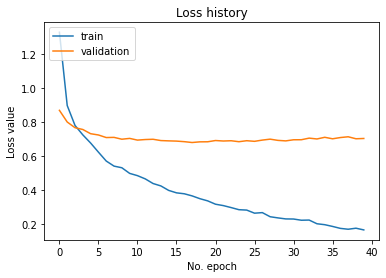

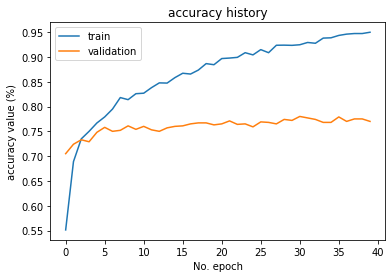

In [119]:
show_history(history)

Solo con un dataset de 5000 elementos y una red de 200 neuronas podemos obtener un modelo para clasificar vehículos con un accuracy del 77%

También podemos construir el nuevo modelo de la siguiente manera

In [120]:
# creamos el nuevo modelo

# El input del nuevo modelo será el mismo que el modelo base
input = model.input

# Seleccionamos hasta que capa del modelo base queremos conservar
last_layer_model_base = model.layers[-4].output

# Creamos la parte que deseamos del modelo transferido
base_model_cut = Model(inputs=input, outputs=last_layer_model_base)

# procesamos el input con la parte del modelo base
layer = base_model_cut(input)

# Creamos el modelo de clasificación que irá encima del modelo base modificado
layer = Flatten()(layer)
layer = Dropout(0.6)(layer)
layer = Dense(units=200, activation='relu')(layer)
output = Dense(units=10, activation='softmax')(layer)

# creamos el modelo
new_model = Model(inputs=input, outputs=output)
print(new_model.summary())

# congelamos las capas no densas para que no sean modificadas durante el entrenamiento
for layer in new_model.layers:
    if not 'dense' in layer.name:
        layer.trainable = False

# compilamos el modelo y entrenamos
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', restore_best_weights=True)
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = new_model.fit(x=X_train_vehicles, y=y_train_vehicles, batch_size=40, epochs=40,
                        validation_data=(X_validation_vehicles, y_validation_vehicles), callbacks=[early_stopping])

Model: "functional_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
functional_97 (Functional)   (None, 1600)              57800     
_________________________________________________________________
flatten_32 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 1600)              0         
_________________________________________________________________
dense_91 (Dense)             (None, 200)               320200    
_________________________________________________________________
dense_92 (Dense)             (None, 10)                2010      
Total params: 380,010
Trainable params: 322,210
Non-trainable params: 57,800
__________________________________________

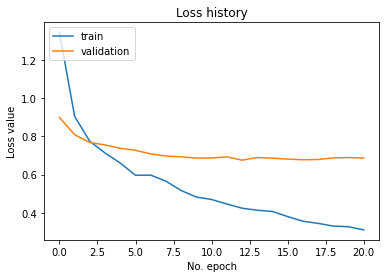

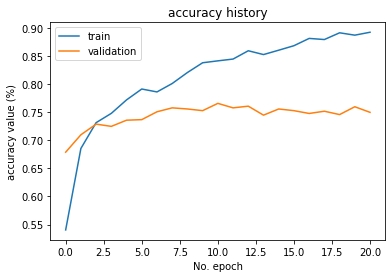

In [121]:
show_history(history)

### Modelos sin Transfer Learning
Entrenemos ahora sobre el mismo dataset 2 modelos entrenados desde 0, sin aplicar la técnica de Transfer Learning.
El primer modelo es una red convolucional.

In [9]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
# capas de la red
input = Input(shape=(32,32,3))
layer = input
layer = Conv2D(filters=25, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = BatchNormalization()(layer)
layer = Conv2D(filters=50, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = BatchNormalization()(layer)
layer = Conv2D(filters=100, kernel_size=3, strides=1, padding='same', activation='relu')(layer)
layer = MaxPooling2D((2, 2))(layer)
layer = BatchNormalization()(layer)
layer = Flatten()(layer)
layer = Dropout(0.5)(layer)
layer = Dense(units=500, activation='relu')(layer)
output = Dense(units=10, activation='softmax')(layer)

# creamos el modelo
model = Model(inputs=input, outputs=output)
print(model.summary())

# optimizador
optimizer = Adam(learning_rate=0.001)

# función loss
loss = SparseCategoricalCrossentropy(from_logits=False)

# métrica
metrics = ['accuracy']

# Podemos decidir que score queremos monitorizar, cuantas epochs esperar después del mejor score y si queremos que nos devuelva el mejor modelo.
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, mode='max')

# compilamos el modelo y entrenamos
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', restore_best_weights=True)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = model.fit(x=X_train_vehicles, y=y_train_vehicles, batch_size=40, epochs=30,
                        validation_data=(X_validation_vehicles, y_validation_vehicles), callbacks=[early_stopping])

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 25)        700       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 25)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 25)        100       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 50)        11300     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 50)          0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 8, 50)         

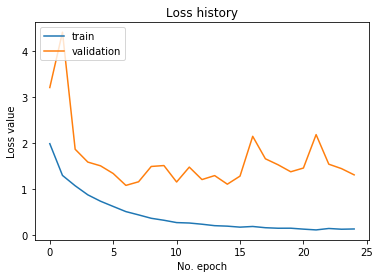

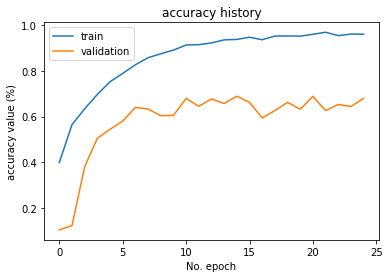

In [10]:
show_history(history)

El score obtenido es del 68%, es decir, un 40% peor que el modelo que usa Transfer Learning.
Además el coste computacional es mucho mayor, 2ms vs 38ms en cada step de entrenamiento.
Entrenemos ahora un modelo con una capacidad de computo similar al modelo que usa Transfer Learning.

In [7]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
# capas de la red
input = Input(shape=(32,32,3))
layer = input
layer = Flatten()(layer)
layer = Dropout(0.5)(layer)
layer = Dense(units=200, activation='relu')(layer)
output = Dense(units=10, activation='softmax')(layer)

# creamos el modelo
model = Model(inputs=input, outputs=output)
print(model.summary())

# optimizador
optimizer = Adam(learning_rate=0.001)

# función loss
loss = SparseCategoricalCrossentropy(from_logits=False)

# métrica
metrics = ['accuracy']

# Podemos decidir que score queremos monitorizar, cuantas epochs esperar después del mejor score y si queremos que nos devuelva el mejor modelo.
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, mode='max')

# compilamos el modelo y entrenamos
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', restore_best_weights=True)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = model.fit(x=X_train_vehicles, y=y_train_vehicles, batch_size=40, epochs=30,
                    validation_data=(X_validation_vehicles, y_validation_vehicles), callbacks=[early_stopping])

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 3072)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 200)               614600    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                2010      
Total params: 616,610
Trainable params: 616,610
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
125/125 [==============================] - 1s 5ms/step - loss: 2.2260 - accuracy: 0.2132 - val_los

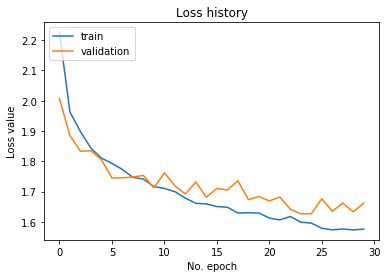

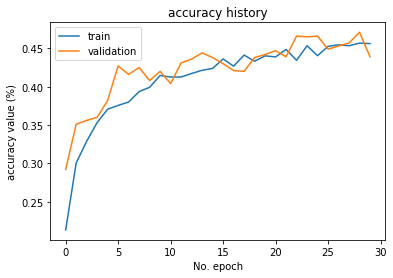

In [8]:
show_history(history)

El score obtenido es del 47%, es decir, un 130% peor que el modelo que usa Transfer Learning.
Estos resultados nos muestran la gran utilidad que tiene el Transfer Learning, tanto en velocidad de entrenamiento como en score.